# Churn prediction 25/26 - Project for Data Science and AI for Business
Authors: Andreea Patarlageanu and Martin Lau

In [68]:
# We will put all imports here
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

**EDITOR NOTES**

- changed structure of the document a bit. do EDA first, then start changing columns or mappings with feature engineering.
- Added more to feature engineering part

## 1. Exploratory Data Analysis

We will start with an exploratory data analysis in order to better understand the data and format it efficiently for later.

### Loading data, checking features

#### Load data

In [2]:
file_path = "Data/train.parquet"

if os.path.exists(file_path):
    df = pd.read_parquet(file_path)
    print("File exists and loaded successfully in df.")
else:
    print("Error: file does not exist.")

File exists and loaded successfully in df.


In [3]:
df.shape

(17499636, 19)

In [4]:
df.head(5)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


#### Understanding each feature.

In this section, we break down each column to get a full understanding of what each information our dataset can give us. 

Some features are self explanatory:
- `userId`: Internal user ID given to unique accounts. Seems arbitrarily determined.
- `sessionId`: Internal session ID given to unique sessions. Seems arbitrarily determined.
- `ts`: Linux time stamp.
- `gender`: Male or female (we shall map 0 or 1 to each gender later).
- `location`: Geographical location
- `registration`: Time stamp for when the user ID has registered onto the platform.
- `song`, `artist`, `time`: What song/artist they played in that session, at what time. 
- `length`: Length of the song played (According to Google, *Seven Nation Army* is a 3 minute 52 second song, or 232 seconds).
- `firstName`, `lastName`: It doesn't take a genius to figure this one out.

The `status` column corresponds to HTTP codes. (200: OK, 307: Temporary redirect, 404: Not found)

In [5]:
print(df['status'].unique())

[200 307 404]


The `level` column corresponds to different subscription plans the user has signed up to.

In [6]:
print(df['level'].unique())

['paid' 'free']


The `page` column corresponds to the page the user's session is currently in.

In [7]:
print(df['page'].unique())

['NextSong' 'Downgrade' 'Help' 'Home' 'Thumbs Up' 'Add Friend'
 'Thumbs Down' 'Add to Playlist' 'Logout' 'About' 'Settings'
 'Save Settings' 'Cancel' 'Cancellation Confirmation' 'Submit Downgrade'
 'Roll Advert' 'Upgrade' 'Error' 'Submit Upgrade']


The `userAgent` corresponds to the platform the user is logging onto the platform with.

In [8]:
print(f"Number of unique user Agents: {len(df['userAgent'].unique())}")
print(df['userAgent'].unique()[:5])

Number of unique user Agents: 85
['"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'
 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0'
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"'
 'Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20100101 Firefox/31.0']


The `method` corresponds to HTTP methods. PUT = update or replace existing element, GET = retrieve HTTP element.   

In [9]:
print(df['method'].unique())

['PUT' 'GET']


#### Inspecting the test dataset.

It is important we check the test dataset to see if there are any large differences between our train and test sets.

In [10]:
df_test = pd.read_parquet("Data/test.parquet")

In [11]:
test_pages = set(df_test['page'].dropna().unique())
train_pages = set(df['page'].dropna().unique())

only_in_test = test_pages - train_pages
print("Pages in test but NOT in train:")
print(only_in_test)

only_in_train = train_pages - test_pages
print("\nPages in train but NOT in test:")
print(only_in_train)

Pages in test but NOT in train:
{'Submit Registration', 'Register', 'Login'}

Pages in train but NOT in test:
{'Cancellation Confirmation', 'Cancel'}


In [12]:
print(df_test['auth'].unique())
print(df['auth'].unique())

['Logged In' 'Logged Out' 'Guest']
['Logged In' 'Cancelled']


**2 key observations from the test dataset vs the train dataset:**

1. In the train, we observe that there is a cancellation confirmation and cancel in the page column. We infer that this should be how we determine whether a user has churned or not. In the test, there are people signing up for the service, and not the other way around.
2. Different values in the auth column. The test set has `Logged Out` and `Guest`, while all users in the train set are logged in.

##### Checking the Guest and LoggedOut sessions.

In [13]:
guest_rows = df_test[df_test['auth'] == 'Guest']
guest_rows.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
63324,404,None,None,free,None,1261737,1538377625000,Guest,Error,15008,None,0,None,GET,NaN,None,None,2018-10-01 07:07:05,2018-10-01 00:00:08
64030,200,None,None,free,None,1261737,1538377871000,Guest,Home,15008,None,1,None,GET,NaN,None,None,2018-10-01 07:11:11,2018-10-01 00:00:08
64320,200,None,None,free,None,1261737,1538377969000,Guest,About,15008,None,2,None,GET,NaN,None,None,2018-10-01 07:12:49,2018-10-01 00:00:08
64518,200,None,None,free,None,1261737,1538378050000,Guest,Help,15008,None,3,None,GET,NaN,None,None,2018-10-01 07:14:10,2018-10-01 00:00:08
65045,200,None,None,free,None,1261737,1538378238000,Guest,Home,15008,None,4,None,GET,NaN,None,None,2018-10-01 07:17:18,2018-10-01 00:00:08


Looks like people looking around at information on the music service. 

In [14]:
logged_out = df_test[df_test['auth'] == 'Logged Out']
logged_out.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
17,200,None,None,paid,None,1261737,1538352008000,Logged Out,Home,8615,None,87,None,GET,NaN,None,None,2018-10-01 00:00:08,2018-10-01 00:00:08
71,307,None,None,free,None,1261737,1538352041000,Logged Out,Login,7433,None,0,None,PUT,NaN,None,None,2018-10-01 00:00:41,2018-10-01 00:00:08
354,200,None,None,free,None,1261737,1538352182000,Logged Out,Home,25003,None,4,None,GET,NaN,None,None,2018-10-01 00:03:02,2018-10-01 00:00:08
472,200,None,None,free,None,1261737,1538352254000,Logged Out,Home,9930,None,2,None,GET,NaN,None,None,2018-10-01 00:04:14,2018-10-01 00:00:08
476,307,None,None,free,None,1261737,1538352255000,Logged Out,Login,9930,None,3,None,PUT,NaN,None,None,2018-10-01 00:04:15,2018-10-01 00:00:08


#### Inspecting the submission file structure

It may also be helpful to see what the example submission looks like, to see what is expected.

In [15]:
target = pd.read_csv("Data/example_submission.csv")
print(f"Length of submission example: {len(target)} rows.")

Length of submission example: 2904 rows.


In [16]:
target.head(10)

,id,target
0,1128274,0
1,1782451,1
2,1611542,1
3,1241663,0
4,1653104,1
5,1486416,1
6,1442381,1
7,1117734,1
8,1212570,1
9,1755776,1


This lets us see what we need to predict.

## 2. Feature engineering

### Preliminary column transformations

Now, let's inspect a bit more the content of the columns that we think it would make sense to change the type:

In [17]:
print(df.columns)
print(df.dtypes)

Index(['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration'],
      dtype='object')
status                    int64
gender                   object
firstName                object
level                    object
lastName                 object
userId                   object
ts                        int64
auth                     object
page                     object
sessionId                 int64
location                 object
itemInSession             int64
userAgent                object
method                   object
length                  float64
song                     object
artist                   object
time             datetime64[us]
registration     datetime64[us]
dtype: object


We see that the order of the columns is not good. Moreover, some types can be changed for a better model comprehension.

First, let's reorder the columns like following:
- *User identifiers*
- *session information*
- *timestamps*
- *user context*
- *action data*
- *content listened to*

In [18]:
print(df['status'].unique())
print(df['level'].unique())
print(df['page'].unique())
print(df['method'].unique())
print(df['auth'].unique())
print(df['page'].unique())

[200 307 404]
['paid' 'free']
['NextSong' 'Downgrade' 'Help' 'Home' 'Thumbs Up' 'Add Friend'
 'Thumbs Down' 'Add to Playlist' 'Logout' 'About' 'Settings'
 'Save Settings' 'Cancel' 'Cancellation Confirmation' 'Submit Downgrade'
 'Roll Advert' 'Upgrade' 'Error' 'Submit Upgrade']
['PUT' 'GET']
['Logged In' 'Cancelled']
['NextSong' 'Downgrade' 'Help' 'Home' 'Thumbs Up' 'Add Friend'
 'Thumbs Down' 'Add to Playlist' 'Logout' 'About' 'Settings'
 'Save Settings' 'Cancel' 'Cancellation Confirmation' 'Submit Downgrade'
 'Roll Advert' 'Upgrade' 'Error' 'Submit Upgrade']


In [19]:
order_columns = [
    'userId',
    'firstName', 
    'lastName',
    'gender',
    'registration',
    
    'sessionId',
    'itemInSession',
    
    'ts',
    'time',
    
    'level',
    'auth',
    'location',
    'userAgent',
    
    'page',
    'method',
    'status',
    
    'song',
    'artist',
    'length'
]

In [20]:
df = df[order_columns]

Now, let's change some of the columns in the proper types:

- gender should be binary: 0 for 'F' and 1 for 'M'
- the level, meaning the level of the subscription, can be free or paid so we set: 0 for 'free' and 1 for 'paid'
- the page action shows the actions of the users/pages visited. Since there are many categories, we will leave that column's type to be 'object'
- the method (HTTP request methods) we set to be 0 for GET (retrieving/viewing data - reading) and 1 for PUT (sending/updating data - writing, like saving a song)
- for 'auth', let's set 0 for 'Cancelled' and 1 for 'Logged In'

In [21]:
df["gender"] = df["gender"].map({'F':0, 'M':1})
df["level"] = df["level"].map({'free' : 0, 'paid': 1})
df["method"] = df["method"].map({'GET' : 0, 'PUT' : 1 })

# ! THIS WORKS ONLY ON TRAIN, NOT ON TEST !
df["auth"] = df["auth"].map({'Cancelled' : 0, 'Logged In' : 1 }) 

Moreover, we see that 'userId''s type is object. Let's see if there are values in this column which cannot be converted to int:

In [22]:
try:
    df['userId'].astype(int)
    df['userId'] = df['userId'].astype(int)
    print("Only integers in userId - transformation successful")
except Exception as e:
    print(f"Some non integer values in userId: {e}")

Only integers in userId - transformation successful


Finally, we create the target columns based on churn.

In [23]:
churned_users = df[df['page'] == 'Cancellation Confirmation']['userId'].unique()
df['churned'] = df['userId'].isin(churned_users).astype(int)

Let's go again through the types of the columns:

In [24]:
df.dtypes

userId                    int32
firstName                object
lastName                 object
gender                    int64
registration     datetime64[us]
sessionId                 int64
itemInSession             int64
ts                        int64
time             datetime64[us]
level                     int64
auth                      int64
location                 object
userAgent                object
page                     object
method                    int64
status                    int64
song                     object
artist                   object
length                  float64
churned                   int32
dtype: object

In [25]:
df.head()

,userId,firstName,lastName,gender,registration,sessionId,itemInSession,ts,time,level,auth,location,userAgent,page,method,status,song,artist,length,churned
0,1749042,Shlok,Johnson,1,2018-08-08 13:22:21,22683,278,1538352001000,2018-10-01 00:00:01,1,1,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",NextSong,1,200,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,524.32934,1
992,1749042,Shlok,Johnson,1,2018-08-08 13:22:21,22683,279,1538352525000,2018-10-01 00:08:45,1,1,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",NextSong,1,200,Monster (Album Version),Skillet,178.02404,1
1360,1749042,Shlok,Johnson,1,2018-08-08 13:22:21,22683,280,1538352703000,2018-10-01 00:11:43,1,1,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",NextSong,1,200,Seven Nation Army,The White Stripes,232.61995,1
1825,1749042,Shlok,Johnson,1,2018-08-08 13:22:21,22683,281,1538352935000,2018-10-01 00:15:35,1,1,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",NextSong,1,200,Under The Bridge (Album Version),Red Hot Chili Peppers,265.50812,1
2366,1749042,Shlok,Johnson,1,2018-08-08 13:22:21,22683,282,1538353200000,2018-10-01 00:20:00,1,1,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",NextSong,1,200,Circlesong 6,Bobby McFerrin,471.69261,1


### Missing values

In [26]:
df.isnull().sum()

userId                 0
firstName              0
lastName               0
gender                 0
registration           0
sessionId              0
itemInSession          0
ts                     0
time                   0
level                  0
auth                   0
location               0
userAgent              0
page                   0
method                 0
status                 0
song             3208203
artist           3208203
length           3208203
churned                0
dtype: int64

We see that the columns 'song', 'artist' and 'length' have the same number of missing values. This might indicate the possibility of having the missing values in the same lines for all 3 columns. Let's check that:

In [27]:
song_missing = df['song'].isnull()
artist_missing = df['artist'].isnull()
length_missing = df['length'].isnull()

# Let's check if they all occur in the same rows:
print("Are all missing in the same rows? Answer: ", (song_missing == artist_missing).all() and (artist_missing == length_missing).all() )

Are all missing in the same rows? Answer:  True


So we see that all the missing values of the 3 columns appear in the same lines. Let's check what percentage of the data all these lines represent:

In [28]:
rows_missing_values = song_missing.sum()
percentage = rows_missing_values / df.shape[0] * 100
print(f"Percentage of rows with missing values: {percentage:.2f}%" )

Percentage of rows with missing values: 18.33%


#TODO: should we delete or keep??????????????????

Now, we will just make sure that the values in 'registration' and 'time' make sense (not too long ago, or in the future):

In [29]:
print("Range of dates in the registration column:")
print(f"Earliest registration: {df['registration'].min()}")
print(f"Latest registration: {df['registration'].max()}")

print()

print("Range of dates in the time column:")
print(f"Earliest time: {df['time'].min()}")
print(f"Latest time: {df['time'].max()}")

Range of dates in the registration column:
Earliest registration: 2017-10-14 22:05:25
Latest registration: 2018-11-19 23:34:34

Range of dates in the time column:
Earliest time: 2018-10-01 00:00:01
Latest time: 2018-11-20 00:00:00


We see that the earliest time was almost one year after the earliest registration.

#TODO: what do we do in this case?????????????????????????????????????

### Row aggregation by userID

We remove the following columns as we deem that they will not influence whether a user will churn or not.
- `firstName` and `lastName` (independence from churn)
- `sessionId` (arbitrary, independent from churn)

Since the task is to predict whether a user will churn, given a user ID and other session data, it makes the most sense to aggregate all rows by userID. For each user ID, we can then fill out different information:
- `userID` 
- `gender`
- `n_sessions`
- `avg_session_length`
- `location`
- `registration`
- `n_songs`
- `n_artists`
- `churn` (target)

In [31]:
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df['registration'] = pd.to_datetime(df['registration'])

df['session_length'] = df.groupby(['userId', 'sessionId'])['ts'].transform(lambda x: x.max() - x.min())
df['song_played'] = df['page'] == 'NextSong'

user_df = df.groupby('userId').agg({
    'gender': 'first',
    'registration': 'first',
    'location': 'last',
    'level': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'sessionId': 'nunique',  # number of sessions
    'itemInSession': 'max',
    'ts': ['min', 'max'],
    'session_length': 'mean',
    'song_played': 'sum',
    'artist': pd.Series.nunique,
    'length': 'sum',
    'churned': 'max'    
}).reset_index()

user_df.columns = ['userId', 'gender', 'registration', 'location', 'level',
                   'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max', 'avg_session_length',
                   'num_songs_played', 'unique_artists', 'total_length', 'churned']

user_df['days_active'] = (user_df['ts_max'] - user_df['ts_min']).dt.days
user_df['membership_length'] = (user_df['ts_max'] - user_df['registration']).dt.days

In [32]:
user_df

,userId,gender,registration,location,level,num_sessions,max_item_in_session,ts_min,ts_max,avg_session_length,num_songs_played,unique_artists,total_length,churned,days_active,membership_length
0,1000025,1,2018-07-10 09:30:08,"New Haven-Milford, CT",1,17,486,2018-10-02 08:59:29,2018-10-18 20:33:05,0 days 13:42:02.882294264,1662,1162,417296.59169,1,16,100
1,1000035,0,2018-09-12 19:28:22,"Columbia, SC",1,21,228,2018-10-05 18:29:46,2018-11-15 03:53:11,0 days 07:31:30.928020565,1266,916,310364.86590,0,40,63
2,1000083,1,2018-09-07 18:01:49,"Cincinnati, OH-KY-IN",1,11,171,2018-10-01 05:37:45,2018-10-12 10:04:58,0 days 06:07:04.669463087,501,427,122606.27093,1,11,34
3,1000103,0,2018-09-22 07:27:25,"Cleveland-Elyria, OH",0,3,53,2018-10-04 17:31:17,2018-11-08 18:28:40,0 days 02:02:59.360000,57,56,13554.73009,0,35,47
4,1000164,0,2018-08-12 09:32:01,"Phoenix-Mesa-Scottsdale, AZ",1,15,215,2018-10-01 17:40:18,2018-11-19 13:04:25,0 days 08:36:20.251945525,847,660,209060.65753,0,48,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19135,1999781,1,2018-08-31 02:26:28,"San Diego-Carlsbad, CA",1,37,679,2018-10-01 05:53:44,2018-11-19 16:41:31,0 days 17:24:32.426458938,3165,1890,798275.42382,0,49,80
19136,1999847,0,2018-09-26 04:22:19,"Columbus, OH",1,4,266,2018-10-04 17:19:17,2018-10-18 02:10:46,0 days 10:04:51.588652482,322,289,81391.63189,1,13,21
19137,1999848,1,2018-08-31 07:58:01,"San Francisco-Oakland-Hayward, CA",0,29,172,2018-10-01 14:36:05,2018-11-18 06:28:48,0 days 04:58:44.983715766,1004,758,249532.88020,0,47,78
19138,1999892,0,2018-08-20 15:55:52,"Virginia Beach-Norfolk-Newport News, VA-NC",0,11,94,2018-10-05 15:34:27,2018-10-26 22:26:14,0 days 03:10:00.152654867,315,289,78200.62120,1,21,67


## 3. Feature analysis

### Distribution of features

In [36]:
user_df["avg_session_length"].dtypes

dtype('<m8[ns]')

These values can be very large, so we decide to cnvert them from a timedelta object to seconds.

In [37]:
user_df['avg_session_length_seconds'] = user_df['avg_session_length'].dt.total_seconds()

First, let's inspect the distribution of the numerical features.

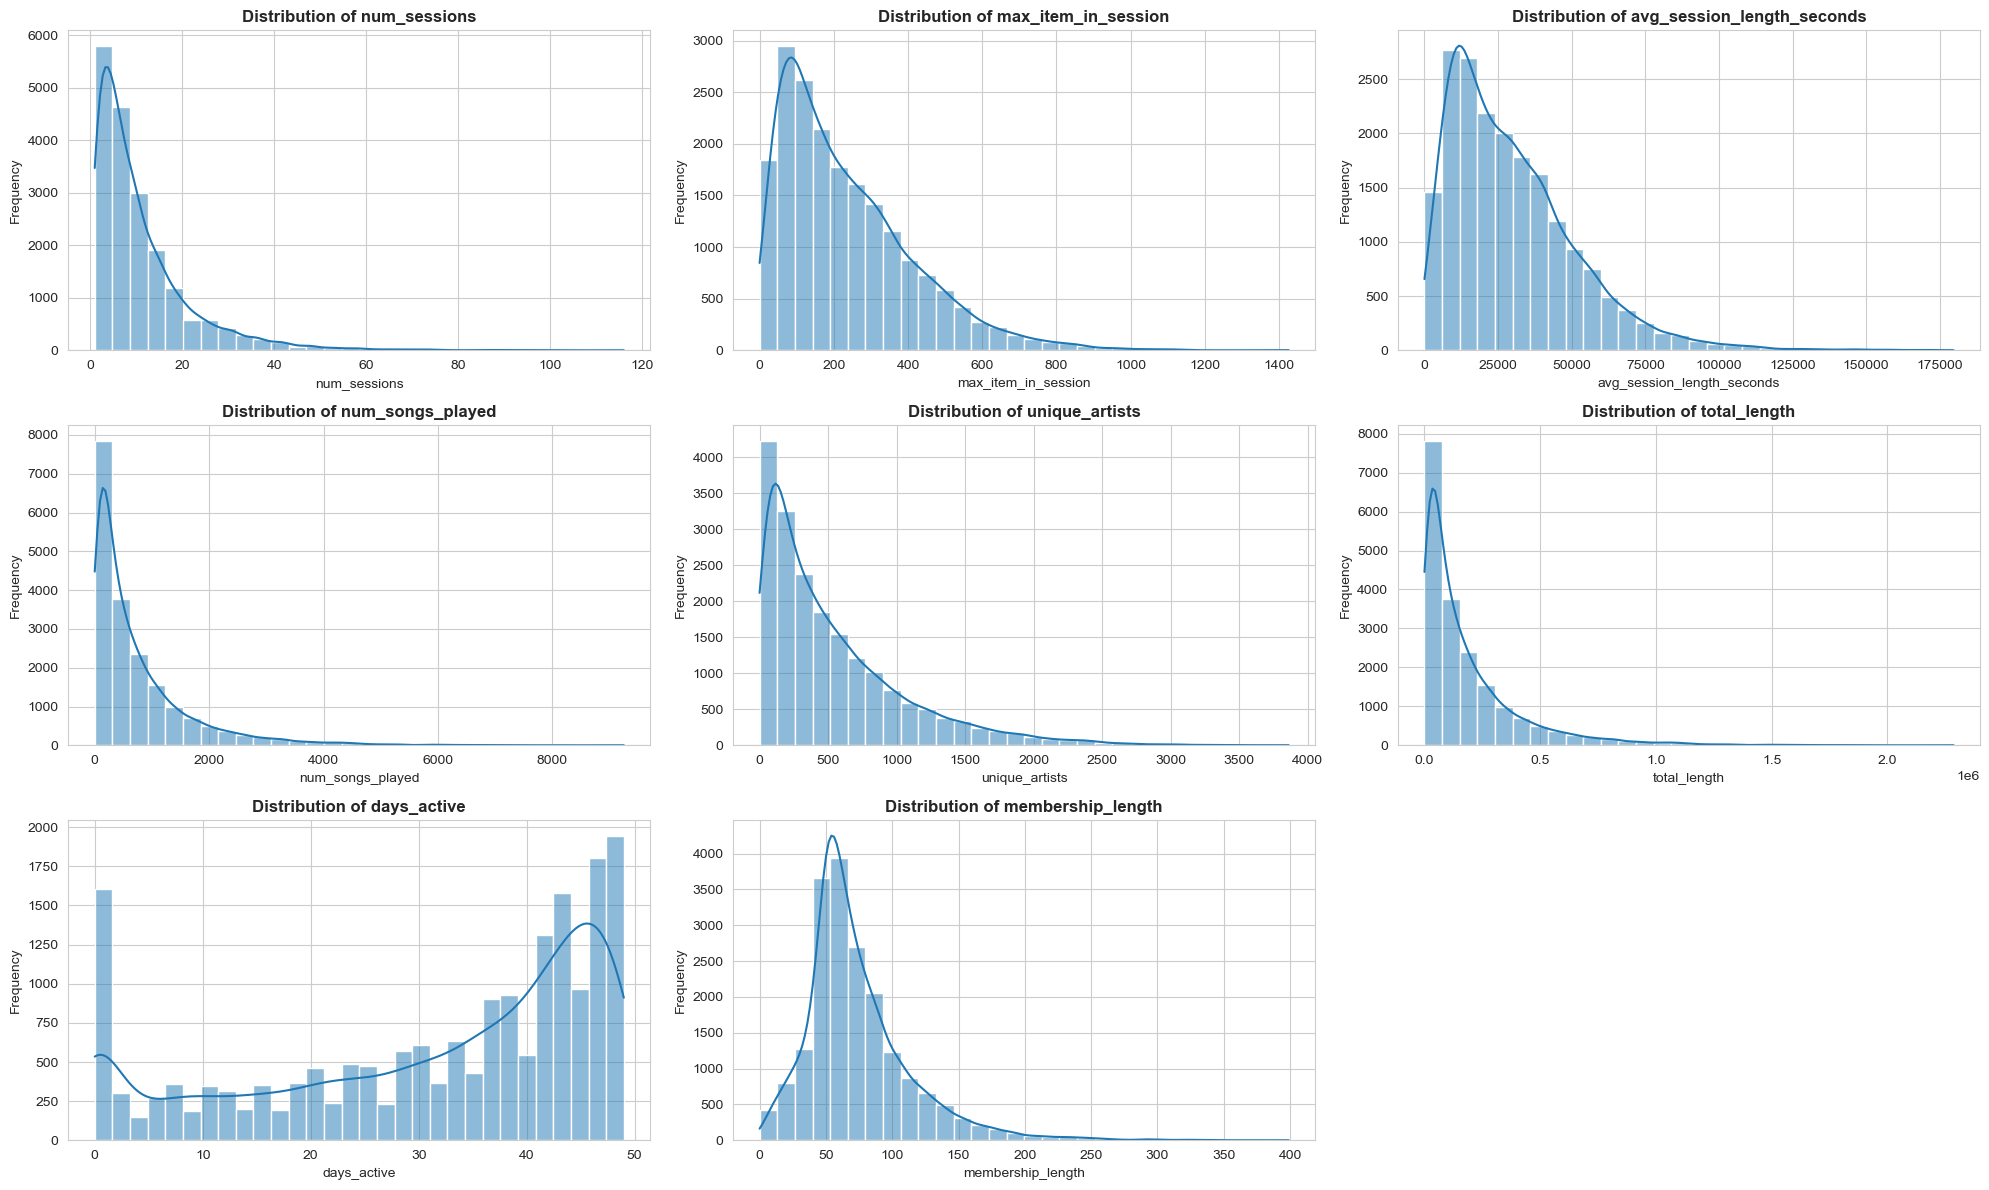

In [40]:
numerical_features = ['num_sessions', 'max_item_in_session', 'avg_session_length_seconds',
                      'num_songs_played', 'unique_artists', 'total_length', 
                      'days_active', 'membership_length']

sns.set_style("whitegrid")

# Let's create a copy of user_df for plotting to avoid modifying the original one
user_df_plot = user_df.copy()

nr_features = len(numerical_features)
n_cols = 3
n_rows = (nr_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    
    # We remove null values for plotting, just to be sure (although we made the inspection before)
    data_to_plot = user_df_plot[feature].dropna()
    
    sns.histplot(data=data_to_plot, kde=True, ax=axes[idx], bins=30)
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

# We remove the unused subplot:
for idx in range(nr_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

*Interpretation*:
We observe that most of our freatures are right-skewed:
1. 'num_sessions', 'max_item_in_sessions', 'avg_session_length_seconds': most of the users have low values, and very few have large values for these 3 features. This means that our data base consists of casual users, and very few highly engaged users
2. 'num_songs_played', 'unique_artists', 'total_length' are also right skewed, following the same pattern as before. This means that the users listen ot very few songs/artists, while there are no many users who have a wide range of songs/artists.
3. 'days_active' has 2 peaks: one around 0 and one around 46 (global maximum) and a 'gap' in the middle. This means that we mostly have 2 types of users: those who stay active for very few days (probably those who churn early, we'll inspect that soon) and those who stay active for mostly all the observation period. There are quite few 'medium' active users.
4. 'membership_length' has it's peak around 50 and is slightly right skewed, meaning that most of our users are kind of new, with a recent membership.

Let's have a summary statistics description:

In [41]:
print(user_df_plot[numerical_features].describe())

       num_sessions  max_item_in_session  avg_session_length_seconds  \
count  19140.000000         19140.000000                19140.000000   
mean      10.885998           235.257419                29830.752753   
std       10.654959           180.104953                21687.513329   
min        1.000000             0.000000                    0.000000   
25%        4.000000            95.000000                13148.374685   
50%        8.000000           191.000000                25298.941752   
75%       14.000000           333.000000                41265.749853   
max      116.000000          1426.000000               179667.568946   

       num_songs_played  unique_artists  total_length   days_active  \
count      19140.000000    19140.000000  1.914000e+04  19140.000000   
mean         746.678840      535.176123  1.857091e+05     31.147910   
std          898.682491      521.360900  2.235359e+05     15.689274   
min            0.000000        0.000000  0.000000e+00      0.000000

Now, let's inspect the categorical features.

C:\Users\andre\AppData\Local\Temp\ipykernel_126176\1251263121.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_df, x=feature, ax=axes[idx], palette='Set1')
C:\Users\andre\AppData\Local\Temp\ipykernel_126176\1251263121.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(label_mappings[feature])
C:\Users\andre\AppData\Local\Temp\ipykernel_126176\1251263121.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_df, x=feature, ax=axes[idx], palette='Set1')
C:\Users\andre\AppData\Local\Temp\ipykernel_126176\1251263121.py:19: UserWarning: set_ticklabels() shoul

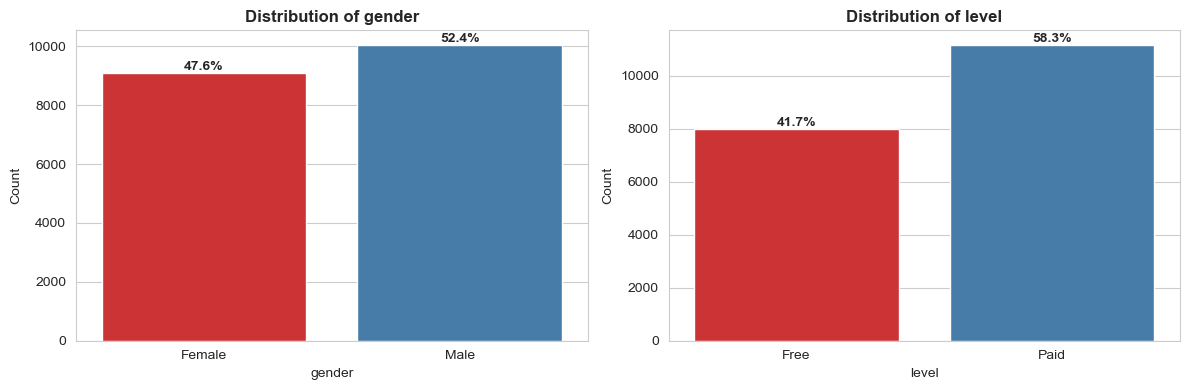

In [73]:
categorical_features = ['gender', 'level']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Define label mappings
label_mappings = {
    'gender': ['Female', 'Male'],
    'level': ['Free', 'Paid']
}

for idx, feature in enumerate(categorical_features):
    sns.countplot(data=user_df, x=feature, ax=axes[idx], palette='Set1')
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=0)
    
    # Set x-axis labels
    axes[idx].set_xticklabels(label_mappings[feature])
    
    total = len(user_df[feature])
    for p in axes[idx].patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'
        axes[idx].text(p.get_x() + p.get_width() / 2., height,
                      percentage,
                      ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

*Interpretation:*

1. For 'gender', we see that there are 47.6% women and 52.4% men, meaning that our dataset is mostly balanced for this feature. Hence, our streaming platform has almost the same nr of men and women as users.
2. For 'level', we see that our data set is quite imbalanced for the paid members (58.3% paid and 41.7% free). We will need to examine the relationship between level and churn. From a business point of view, if the paid members churn, it has a negative impact on the revenu of the company. On another side, users also see the benefits of having a premium membership.

### Target variable distribution

Now, let's see the distribution of our target variable.

C:\Users\andre\AppData\Local\Temp\ipykernel_126176\93911403.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_df, x='churned', palette='Set1')


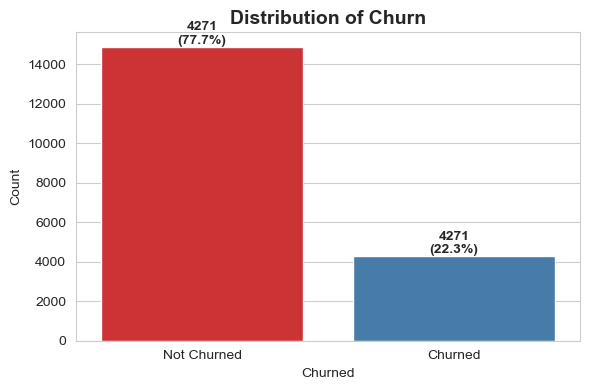

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(data=user_df, x='churned', palette='Set1')
plt.title('Distribution of Churn', fontsize=14, fontweight='bold')
plt.xlabel('Churned')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Churned', 'Churned'])

total = len(user_df['churned'])
for p in plt.gca().patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    count = f'{int(height)}'
    label = f'{count}\n({percentage})'
    plt.text(p.get_x() + p.get_width() / 2., height,
             label,
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

We see that there is a class imbalance between 'churned'(22.3%) and 'not churned'(77.7%). This imbalance can create model bias: our models predict 'not churned' more often; a model predicting 'not churned' all the time will achieve 77.7% accuracy, but this is not the point of this project, we care about those who did churn.

Hence, during modeling, we should use class_weight='balanced', use appropriate evaluation metrics, etc.

### Feature distribution by churn status

In this section, let's inspect how each feature differs between churned and not churned users.

C:\Users\andre\AppData\Local\Temp\ipykernel_126176\2304409578.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=user_df, x='churned', y=feature, ax=axes[idx], palette='Set1')
C:\Users\andre\AppData\Local\Temp\ipykernel_126176\2304409578.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(['Not Churned', 'Churned'])
C:\Users\andre\AppData\Local\Temp\ipykernel_126176\2304409578.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=user_df, x='churned', y=feature, ax=axes[idx], palette='Set1')
C:\Users\andre\AppData\Local\Temp\ipykernel_126176\2304409578.py:13: UserWarning:

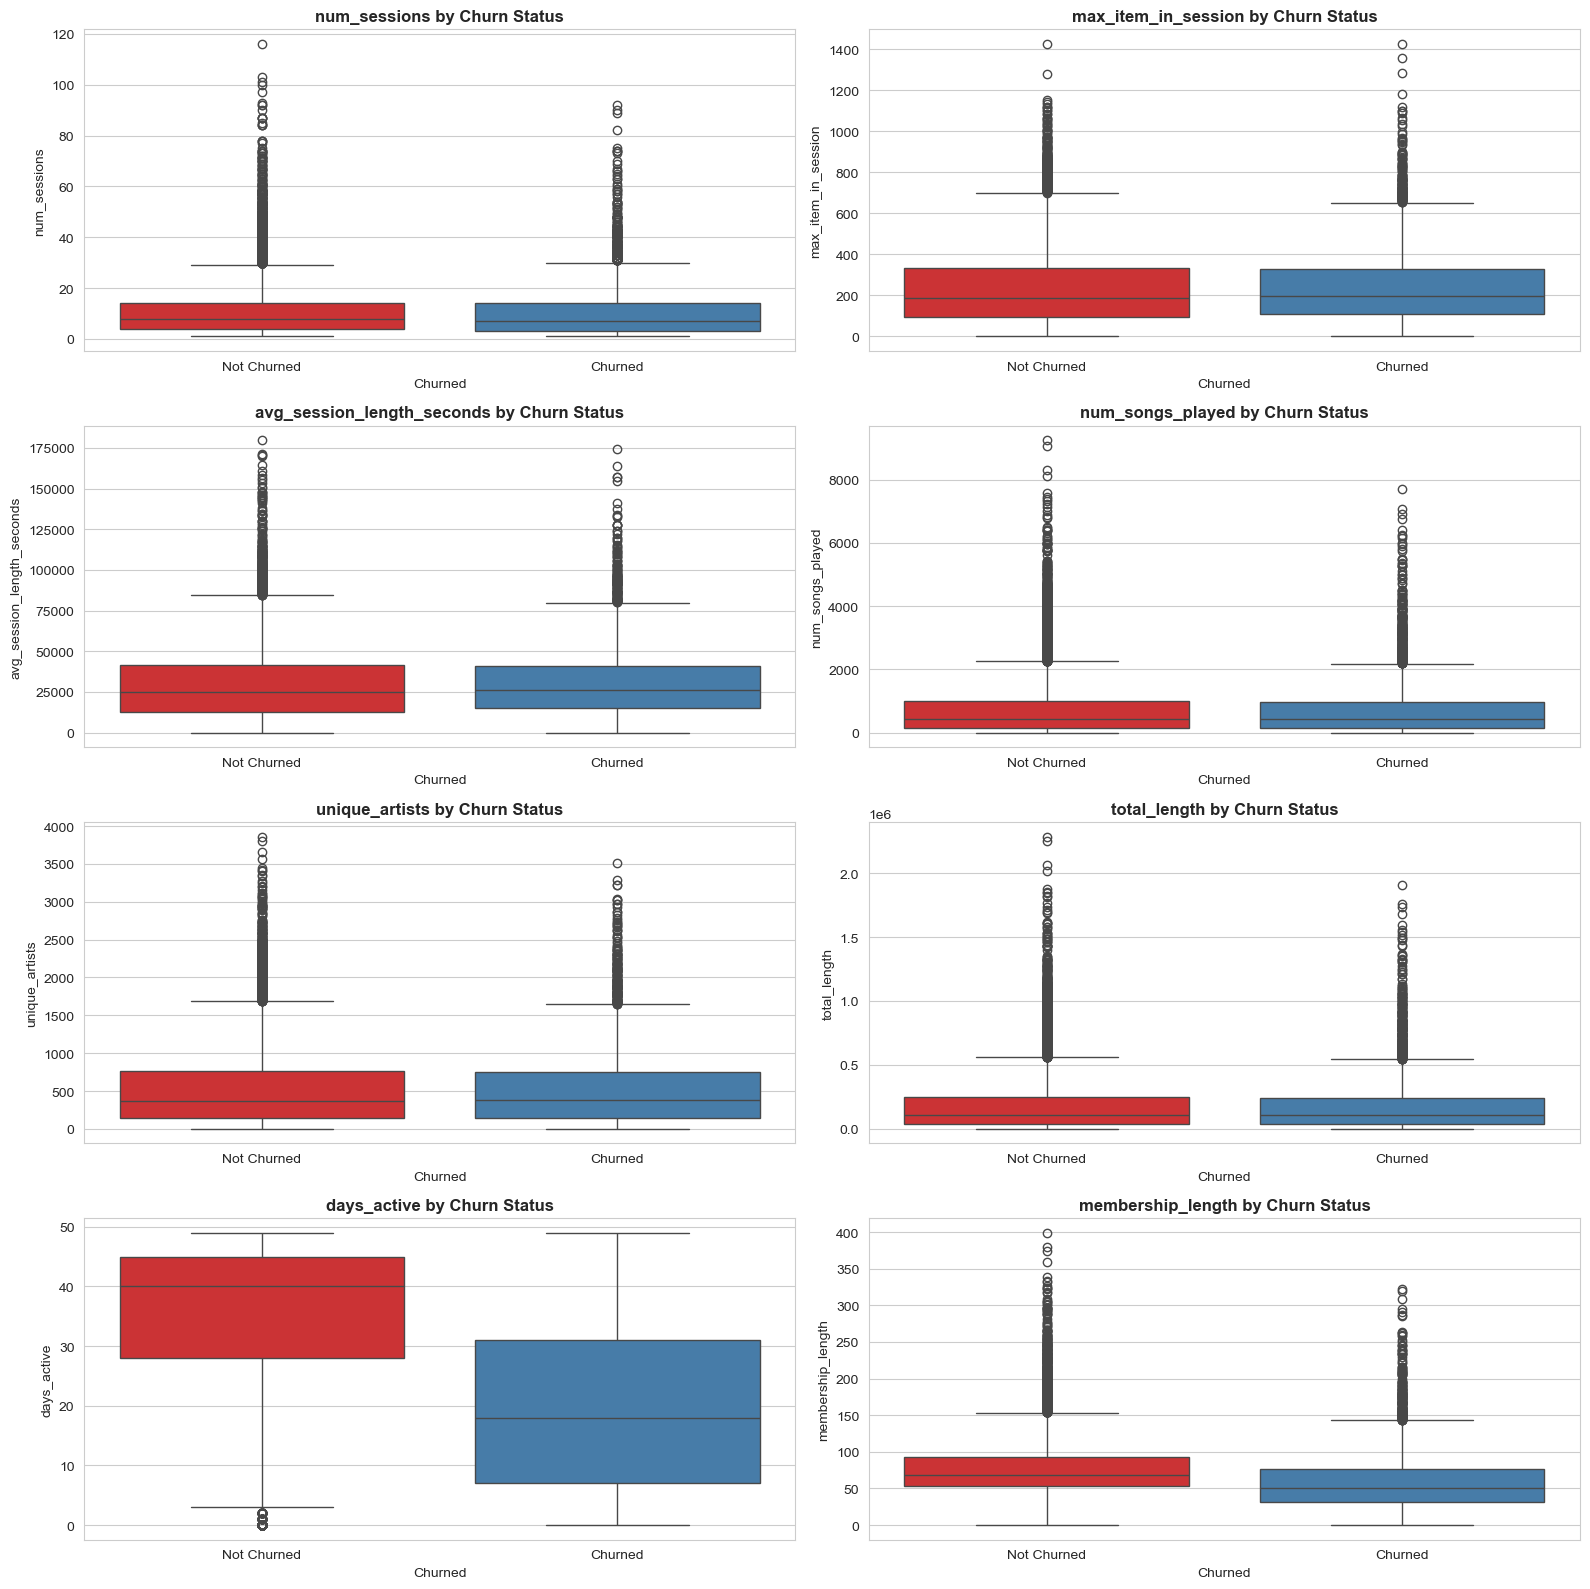

In [63]:
nr_features = len(numerical_features)
n_cols = 2
n_rows = (nr_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=user_df, x='churned', y=feature, ax=axes[idx], palette='Set1')
    axes[idx].set_title(f'{feature} by Churn Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churned')
    axes[idx].set_ylabel(feature)
    axes[idx].set_xticklabels(['Not Churned', 'Churned'])

# Remove extra subplots
for idx in range(nr_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

*Interpretation:*

1. 'days_active': the median for 'not churned' is around 40 days, meanwhile the median for 'churned' is around 18 days, meaning that users who churn stop being active earlier.
2. 'membership_length': same observation, churn members have a shorter membership length.
3. Rest of the features share a similar pattern for both churned and not churned.

We observemany **outliers** in both churned and not churned groups, meaning that even strongly involved users can churn. We keep this in mind for our predictions: we need 2 strategies, one for low engagement users, and another one for highly involved users who suddenly churn.

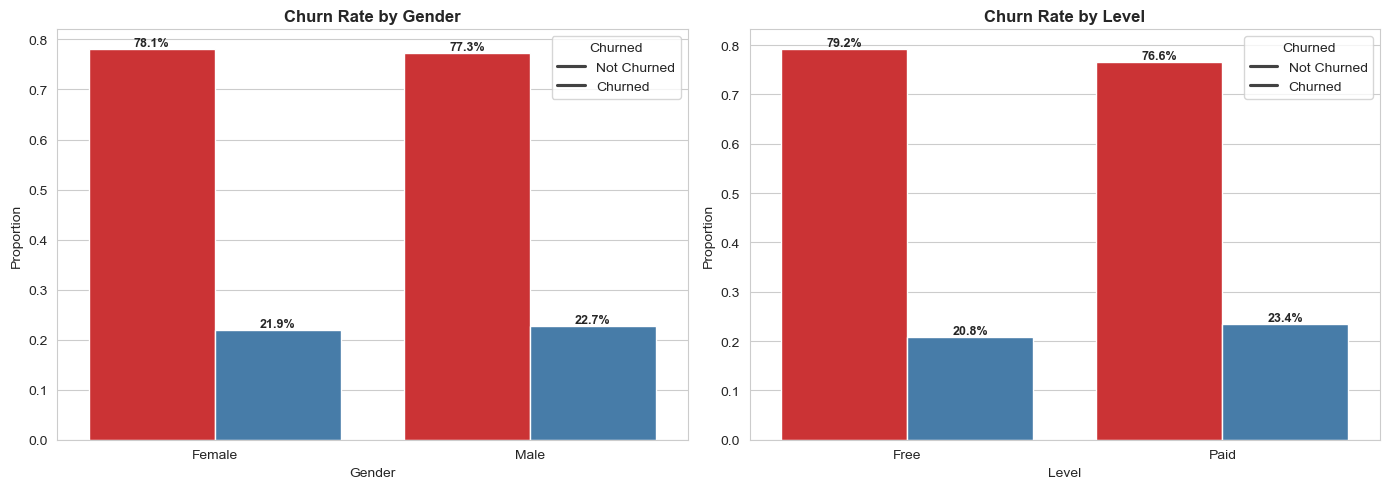

In [ ]:
categorical_features = ['gender', 'level']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

label_mappings = {
    'gender': {0: 'Female', 1: 'Male'},
    'level': {0: 'Free', 1: 'Paid'}
}

for idx, feature in enumerate(categorical_features):
    churn_by_feature = pd.crosstab(user_df[feature], user_df['churned'], normalize='index').reset_index()
    churn_by_feature = churn_by_feature.melt(id_vars=feature, var_name='churned', value_name='proportion')
    
    churn_by_feature[feature] = churn_by_feature[feature].map(label_mappings[feature])
    
    sns.barplot(data=churn_by_feature, x=feature, y='proportion', hue='churned', ax=axes[idx], palette='Set1')
    axes[idx].set_title(f'Churn Rate by {feature.capitalize()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Proportion')
    axes[idx].legend(title='Churned', labels=['Not Churned', 'Churned'])
    
    for p in axes[idx].patches:
        height = p.get_height()
        if height > 0:
            axes[idx].text(p.get_x() + p.get_width() / 2., height,
                          f'{height*100:.1f}%',
                          ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

*Interpretation:*

1. Gender:
    - Females: 78.1% not churned and 21.9% churned
    - Males: 77.3% not churned and 22.7% churned

    Since these ratios are almost identical, it means that churn is equally likely regardless of gender. We will mostly drop gender from our predictions
2. Level:
    - Free users: 79.2% not churned and 20.8% churned
    - Paid users: 76.6% not churned and 23.4% churned
    
    This means that paid users churn more than free users. From a business point of view, this might be because the expectations of the paid membership are higher.

### Correlation with the target

Let's investigate the correlation of the features with the target variable.

In [69]:
correlations = user_df[numerical_features + ['churned']].corr()['churned'].drop('churned').sort_values(ascending=False)

for feature in numerical_features:
    corr, pval = pearsonr(user_df[feature], user_df['churned'])
    print(f"{feature:35}: {corr:7.4f}")

num_sessions                       : -0.0142
max_item_in_session                :  0.0173
avg_session_length_seconds         :  0.0219
num_songs_played                   : -0.0002
unique_artists                     :  0.0013
total_length                       : -0.0002
days_active                        : -0.4050
membership_length                  : -0.1993


The correlations coefficients range from -1 to 1 and they have the following meaning:

1. if it is close to -1, then it has perfect negative correlation
2. close to 0 means non-linear relationship 
3. close to 1 means perfect positive correlation

We observe that 'days_active' and 'membership_length' have the most important correlations.

- If a user is active for more dyas he is less likely to churn
- If a user has a longer membership, he is less likely to churn